The code is developed for the paper "Customer Segmentation Applied On RFM-ID Model"

# Loading Data and Preprocessing

In [17]:
%%capture
%run "rfmvd.ipynb"

In [18]:
rfmvd_scaled = rfmvd_scaled # type: ignore

# Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import DBSCAN
from minisom import MiniSom
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from scipy.special import logsumexp

# Segmentation Algorithms

## K-means

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

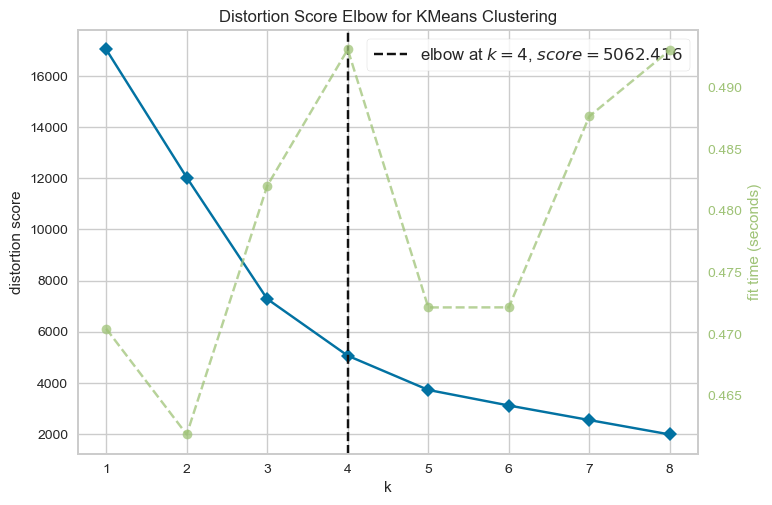

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [448]:
# RFM
vars = ['Recency', 'Frequency', 'Monetary']
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,9))

visualizer.fit(rfmvd_scaled[vars])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [449]:
n = 4 # number of clusters

In [450]:
%%timeit -r1 -n1
kmeans = KMeans(n_clusters=n, max_iter=500, random_state=1)
kmeans.fit(rfmvd_scaled[vars])

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


473 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [451]:
kmeans = KMeans(n_clusters=n, max_iter=500, random_state=1)
kmeans.fit(rfmvd_scaled[vars])

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=500, n_clusters=4, random_state=1)

In [452]:
# RFM

cluster_labels = kmeans.labels_
rfmvd_scaled['Labels'] = cluster_labels
silhouette_avg = silhouette_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the silhouette score is {1}".format(n, silhouette_avg))

cal_avg = calinski_harabasz_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the calinski score is {1}".format(n, cal_avg))

db_index = davies_bouldin_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the davis_bouldin score is {1}".format(n, db_index))



For n_clusters=4, the silhouette score is 0.5846561741869105
For n_clusters=4, the calinski score is 4472.584335852707
For n_clusters=4, the davis_bouldin score is 0.6700970894273075


In [453]:
kmeans.cluster_centers_

array([[-0.83057114,  1.81727117,  1.96530786],
       [ 1.27527923, -0.26333615, -0.284907  ],
       [-0.61153739, -0.06939875, -0.06602898],
       [-0.75159855, 17.30980617, 15.26386196]])

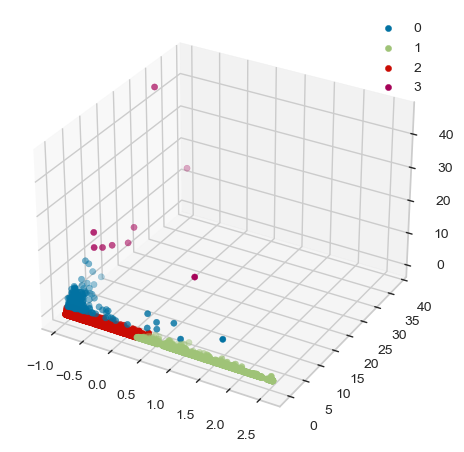

In [454]:
# RFM clustering graph
centroids = kmeans.cluster_centers_
u_labels = np.unique(cluster_labels)
ax = plt.axes(projection='3d')

#plotting the results:
for i in u_labels:
    ax.scatter(rfmvd_scaled[rfmvd_scaled.Labels == i]['Recency'] , rfmvd_scaled[rfmvd_scaled.Labels == i]['Frequency'] , rfmvd_scaled[rfmvd_scaled.Labels == i]['Monetary'], label = i, zorder=1)

 # plotting centroids
# ax.scatter(centroids[:,0] , centroids[:,1] , centroids[:,2], marker='x', 
#                 s=1, linewidths=10, color='b', label='centroid', zorder=100)
ax.legend()
plt.show()

In [455]:
centroids

array([[-0.83057114,  1.81727117,  1.96530786],
       [ 1.27527923, -0.26333615, -0.284907  ],
       [-0.61153739, -0.06939875, -0.06602898],
       [-0.75159855, 17.30980617, 15.26386196]])

In [456]:
n = 3
e = 0.8
s = 1000
double_cluster_df = pd.DataFrame()
centroids_n = []
for i in range(len(centroids)):
    kmeans = KMeans(n_clusters=n, max_iter=500, random_state=1)
    rfm_i = rfmvd_scaled[vars].loc[rfmvd_scaled['Labels'] == i]
    kmeans.fit(rfm_i)
    # kmeans = AgglomerativeClustering(n_clusters=2)
    # kmeans.fit(rfm_i)
    labels = [l+(2*(i**2)) for l in kmeans.labels_] 
    sel_score = calinski_harabasz_score(rfm_i, labels)
    print(sel_score)
    if sel_score:
        rfm_i['Labels'] = labels
        # centroids_n.append(kmeans.cluster_centers_)
        double_cluster_df = pd.concat([double_cluster_df, rfm_i], ignore_index=True)
    else:
        rfm_i['Labels'] = 2*(i**2)
        # centroids_n.append(kmeans.cluster_centers_)
        double_cluster_df = pd.concat([double_cluster_df, rfm_i], ignore_index=True)

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


197.49500453715186


c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


2940.1238797249675


c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


3246.269316397096


c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


20.192780838315322


In [457]:
# RFM

cluster_labels = double_cluster_df['Labels']
rfmvd_scaled['Labels'] = cluster_labels
silhouette_avg = silhouette_score(double_cluster_df[vars], cluster_labels)
print("For n_clusters={0}, the silhouette score is {1}".format(n, silhouette_avg))

cal_avg = calinski_harabasz_score(double_cluster_df[vars], cluster_labels)
print("For n_clusters={0}, the calinski score is {1}".format(n, cal_avg))

db_index = davies_bouldin_score(double_cluster_df[vars], cluster_labels)
print("For n_clusters={0}, the davis_bouldin score is {1}".format(n, db_index))



For n_clusters=3, the silhouette score is 0.38104238058880685
For n_clusters=3, the calinski score is 3395.2254591432807
For n_clusters=3, the davis_bouldin score is 0.934402278844722


In [458]:
print(double_cluster_df.head(2400))

       Recency  Frequency  Monetary  Labels
0    -0.789892   0.712688  1.488044       0
1    -0.957425   1.290078  2.940112       0
2    -0.952639   1.043084  1.817537       0
3    -0.909559   0.930813  1.860521       0
4    -0.952639   2.569960  4.989080       1
...        ...        ...       ...     ...
2395 -0.411745  -0.361899 -0.373073       8
2396 -0.842545  -0.262460 -0.211769       9
2397  0.095642  -0.377938 -0.387665       8
2398 -0.339945  -0.076412  0.037553       8
2399 -0.799465   0.080767  0.371445      10

[2400 rows x 4 columns]


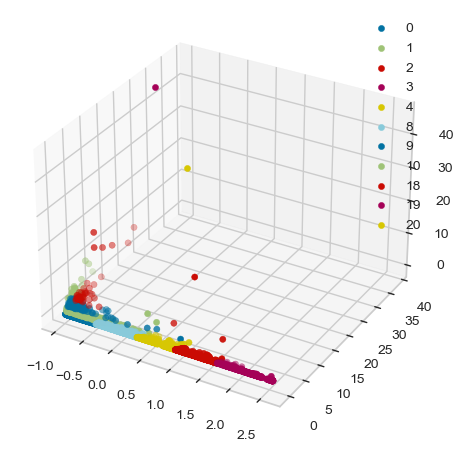

In [459]:
# RFM clustering graph
u_labels = np.unique(double_cluster_df["Labels"])

ax = plt.axes(projection='3d')

#plotting the results:
for i in u_labels:
    ax.scatter(double_cluster_df[double_cluster_df.Labels == i]['Recency'] , double_cluster_df[double_cluster_df.Labels == i]['Frequency'] , double_cluster_df[double_cluster_df.Labels == i]['Monetary'], label = i, zorder=1)

 # plotting centroids
# ax.scatter(centroids[:,0] , centroids[:,1] , centroids[:,2], marker='x', 
#                 s=1, linewidths=10, color='b', label='centroid', zorder=100)
ax.legend()
plt.show()

In [ ]:
# if sel_score:
    #     rfm_i['Labels'] = labels
    #     # centroids_n.append(kmeans.cluster_centers_)
    #     double_cluster_df = pd.concat([double_cluster_df, rfm_i], ignore_index=True)
    # else:
    #     rfm_i['Labels'] = 2*(i**2)
    #     # centroids_n.append(kmeans.cluster_centers_)
    #     double_cluster_df = pd.concat([double_cluster_df, rfm_i], ignore_index=True)

In [ ]:
    # labels = [l+(2*(i**2)) for l in kmeans.labels_] # to give each group a unique label


# SOM

In [ ]:
som_shape = (2, 2)

In [ ]:
som = MiniSom(som_shape[0], som_shape[1], rfmvd_scaled[vars].shape[1], sigma=0.3, learning_rate=0.5, neighborhood_function='gaussian', random_seed=10)
som.random_weights_init(rfmvd_scaled[vars].values)
som.train_random(rfmvd_scaled[vars].values, 100)

In [ ]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in rfmvd_scaled[vars].values]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

In [ ]:
cluster_labels = cluster_index
rfmvd_scaled['Labels'] = cluster_labels
silhouette_avg = silhouette_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the silhouette score is {1}".format(n, silhouette_avg))

cal_avg = calinski_harabasz_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the calinski score is {1}".format(n, cal_avg))

db_index = davies_bouldin_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the davis_bouldin score is {1}".format(n, db_index))

For n_clusters=4, the silhouette score is 0.2876873478905792
For n_clusters=4, the calinski score is 891.9287502673657
For n_clusters=4, the davis_bouldin score is 1.2511280051817195


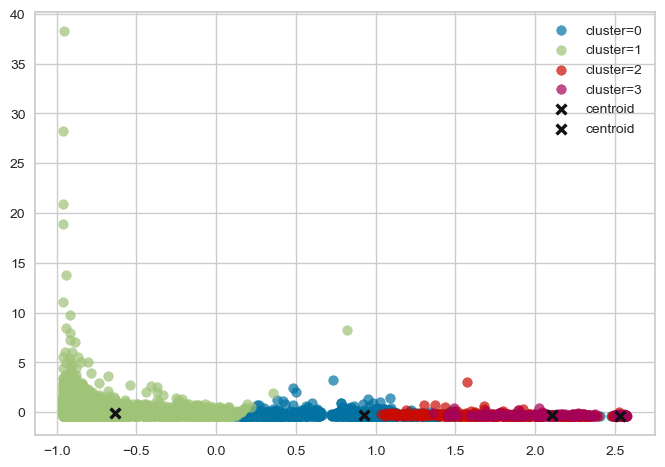

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(rfmvd_scaled[vars].values[cluster_index == c, 0],
                rfmvd_scaled[vars].values[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=3, linewidths=10, color='k', label='centroid')
plt.legend()

In [ ]:
# labels = [last_v+i+l for l in kmeans.labels_]
    # last_v = last_v + i + (nn-1)

# Double Clustring

In [ ]:
rfm_k.head(10) # From k-means

,Recency,Frequency,Monetary,Variety,Duration,Labels
0,1.569937,0.445637,0.061667,-0.144176,-0.544610,2
1,-0.952639,0.184859,0.279279,0.279163,0.238757,0
2,0.229669,-0.162845,-0.183414,-0.144176,0.226229,0
3,-0.871265,-0.249770,-0.009665,-0.250011,2.052693,0
4,0.521656,-0.423622,0.459456,-0.461680,-0.668212,0
5,0.832790,-0.423622,-0.562186,-0.461680,-0.668212,2
6,-0.789892,0.271785,0.035509,0.384997,0.014699,0
7,0.014269,-0.336696,-0.617786,-0.355845,-0.668212,0
8,0.148296,-0.423622,0.153659,-0.461680,-0.668212,0
9,0.062136,-0.336696,0.793054,-0.355845,-0.668212,1


In [ ]:
rfm_k.loc[rfm_k['Labels'] == 2]

,Recency,Frequency,Monetary,Variety,Duration,Labels
0,1.569937,0.445637,0.061667,-0.144176,-0.544610,2
5,0.832790,-0.423622,-0.562186,-0.461680,-0.668212,2
29,1.038617,-0.423622,-0.249438,-0.461680,-0.668212,2
39,1.024257,-0.423622,-0.591376,-0.461680,-0.668212,2
41,0.966817,-0.249770,0.289183,-0.250011,0.654659,2
...,...,...,...,...,...,...
5658,1.866711,-0.075919,-0.229979,-0.038341,-0.292396,2
5659,0.789710,-0.423622,0.000760,-0.461680,-0.668212,2
5669,1.522071,-0.423622,-0.701185,-0.461680,-0.668212,2
5675,2.201778,-0.423622,0.084159,-0.461680,-0.668212,2


In [ ]:
nn = 3
itr = 500
rs = 1
sub_vars = ['Variety', 'Duration']
double_cluster_df = pd.DataFrame()
centroids_n = []
last_v = 0
for i in range(len(centroids_k)):
    kmeans = KMeans(n_clusters=nn, max_iter=itr, random_state=rs)
    rfm_i = rfm_k.loc[rfm_k['Labels'] == i]
    kmeans.fit(rfm_i.loc[:, sub_vars])
    labels = kmeans.labels_
    sel_score = silhouette_score(rfm_i, labels)
    # print(sel_score)
    rfm_i.loc[:, 'Labels2'] = labels
    double_cluster_df = pd.concat([double_cluster_df, rfm_i], ignore_index=True)

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\pc\AppData\Local\Temp\ipykernel_15040\3584832184.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_i.loc[:, 'Labels2'] = labels
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1

In [ ]:
pd.unique(double_cluster_df["Labels"])

array([0, 1, 2, 3], dtype=int64)

In [ ]:
pd.unique(double_cluster_df["Labels2"])

array([0, 1, 2])

In [ ]:
double_cluster_df.head(100)

,Recency,Frequency,Monetary,Variety,Duration,Labels,Labels2
0,-0.952639,0.184859,0.279279,0.279163,0.238757,0,0
1,0.229669,-0.162845,-0.183414,-0.144176,0.226229,0,0
2,-0.871265,-0.249770,-0.009665,-0.250011,2.052693,0,1
3,0.521656,-0.423622,0.459456,-0.461680,-0.668212,0,0
4,-0.789892,0.271785,0.035509,0.384997,0.014699,0,0
...,...,...,...,...,...,...,...
95,-0.914345,-0.249770,-0.127814,-0.250011,-0.127037,0,0
96,0.646110,-0.423622,0.084159,-0.461680,-0.668212,0,0
97,-0.938279,1.227971,0.086661,1.443344,-0.072753,0,2
98,-0.775532,-0.423622,-0.207739,-0.461680,-0.668212,0,0


2


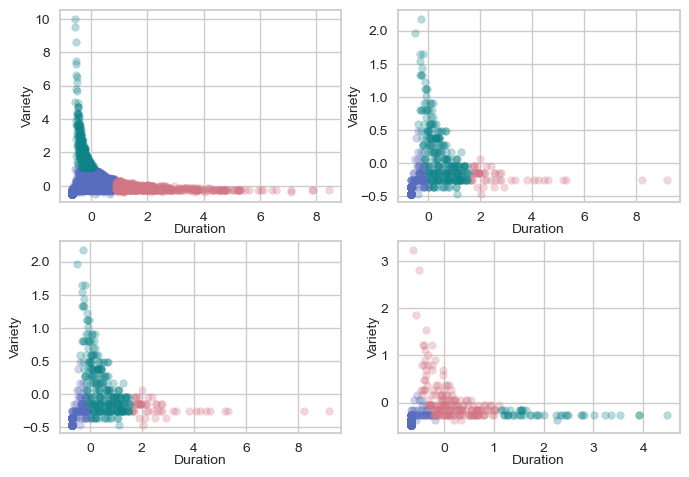

In [ ]:
# DFM clustering graph
u_labels = nn
h = 2
print(h)
# colors = ['brown', 'blue', 'green', 'yellow']
colors = ['#576CBC', '#D27685', '#0E8388']
markers = ['*', '.', '+']
fig, axs = plt.subplots(2, 2)
for i in range(2):
    for l in range(2):
        # if i==1 and n%2!=0 and l==h-1: # for odd number of graphs
        #     break 
        for k in range(3):
            axs[i, l].scatter(double_cluster_df[(double_cluster_df.Labels == i+l) & (double_cluster_df.Labels2 == k)]['Duration'] , double_cluster_df[(double_cluster_df.Labels == i+l) & (double_cluster_df.Labels2 == k)]['Variety'], label = k, s=30, c=colors[k], alpha=0.3)
            axs[i, l].set_xlabel("Duration", labelpad=0, fontsize=10)
            axs[i, l].set_ylabel("Variety", labelpad=0, fontsize=10)
# axs.legend()
plt.show()

In [ ]:
for i in range(4):
    for j in range(3):
        print(double_cluster_df[["Duration", "Labels", "Labels2"]][(double_cluster_df.Labels==i) & (double_cluster_df.Labels2==j)].count(axis=0))

Duration    2640
Labels      2640
Labels2     2640
dtype: int64
Duration    633
Labels      633
Labels2     633
dtype: int64
Duration    327
Labels      327
Labels2     327
dtype: int64
Duration    496
Labels      496
Labels2     496
dtype: int64
Duration    50
Labels      50
Labels2     50
dtype: int64
Duration    253
Labels      253
Labels2     253
dtype: int64
Duration    1040
Labels      1040
Labels2     1040
dtype: int64
Duration    188
Labels      188
Labels2     188
dtype: int64
Duration    44
Labels      44
Labels2     44
dtype: int64
Duration    4
Labels      4
Labels2     4
dtype: int64
Duration    2
Labels      2
Labels2     2
dtype: int64
Duration    1
Labels      1
Labels2     1
dtype: int64


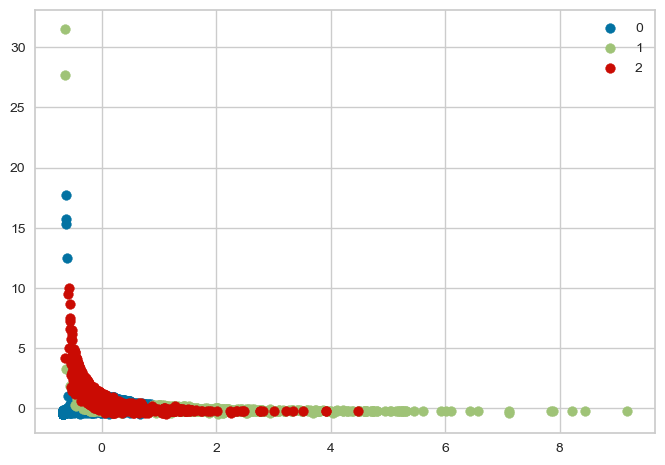

In [ ]:
# DFM clustering graph
u_labels = np.unique(double_cluster_df['Labels'])
ax = plt.axes()
    
for i in [0,1,2]:
    ax.scatter(double_cluster_df[double_cluster_df.Labels2 == i]['Duration'] , double_cluster_df[double_cluster_df.Labels2 == i]['Variety'], label = i)
ax.legend()
plt.show()

# Clustring Over Intervals

In [ ]:
rfm_scaled.head(10)